# Agente Inteligente para Cálculo de Vale Refeição (VR/VA) - Desafio 4

Este notebook implementa a automação do processo mensal de compra de Vale Refeição (VR), consolidando múltiplas bases de dados, aplicando regras de negócio complexas e gerando um arquivo final para o fornecedor.

### 📌 Passo 1 — Instalar Bibliotecas

In [36]:
!pip install pandas openpyxl
!pip install langchain langchain_experimental langchain-openai matplotlib

### 📌 Passo 2 — Configurar Chave de API e importar Ferramentas

In [37]:
# 📌 PASSO 2 — Importar Ferramentas e Configurar Chave de API (Versão Corrigida)

# Imports necessários para o projeto
import pandas as pd
import numpy as np
from datetime import datetime
import os
from google.colab import userdata

# Bibliotecas para o agente de IA
from langchain_openai import ChatOpenAI
from langchain_experimental.agents import create_pandas_dataframe_agent

# Biblioteca para gráficos
import matplotlib.pyplot as plt

# --- Carrega a chave de API diretamente dos Secrets ---
# AQUI ESTÁ A CORREÇÃO:
# Usamos o nome exato que você salvou nos Secrets ('OPENROUTER_APIKEY')
try:
    os.environ["OPENROUTER_API_KEY"] = userdata.get('OPENROUTER_API_KEY')
    print("✅ Chave de API carregada com segurança a partir dos Secrets.")
except Exception as e:
    print(f"❌ Erro ao carregar a chave: {e}")
    print("👉 Verifique se o nome da chave na aba 'Secrets' é exatamente 'OPENROUTER_API_KEY'.")

✅ Chave de API carregada com segurança a partir dos Secrets.


📌 Passo 3 — Conectar ao Google Drive

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 📌 PASSO 4 — Descompactar Arquivo ZIP com as Planilhas

In [39]:

import zipfile
import os

# 1. Caminho atualizado com o nome do seu arquivo ZIP
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Desafio 4 - Dados.zip'

# 2. Caminho atualizado com o nome da sua pasta de destino
extract_dir = '/content/drive/MyDrive/Colab Notebooks/Dados_VR_Descompactados/'

# Cria o diretório de destino se ele não existir
os.makedirs(extract_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Arquivo descompactado com sucesso na pasta: '{extract_dir}'.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo ZIP não encontrado em '{zip_file_path}'. Verifique o nome e o caminho.")
except Exception as e:
    print(f"❌ Ocorreu um erro: {e}")

✅ Arquivo descompactado com sucesso na pasta: '/content/drive/MyDrive/Colab Notebooks/Dados_VR_Descompactados/'.


### 📌 PASSO 5 — Carregar as planilhas

In [40]:
# 📌 PASSO 5 — Carregar as Bases de Dados (Mantendo nomes originais do seu GDrive)

base_path = '/content/drive/MyDrive/Colab Notebooks/Dados_VR_Descompactados/'

try:
    print("--- Carregando bases principais ---")
    df_ativos = pd.read_excel(base_path + 'ATIVOS.xlsx')
    print("📄 Base de ATIVOS.xlsx carregada.")

    df_admitidos = pd.read_excel(base_path + 'ADMISSAO_ABRIL.xlsx')
    print("📄 Base de ADMISSÃO ABRIL.xlsx carregada.")

    df_desligados = pd.read_excel(base_path + 'DESLIGADOS.xlsx')
    print("📄 Base de DESLIGADOS.xlsx carregada.")

    df_ferias = pd.read_excel(base_path + 'FÉRIAS.xlsx') # Com acento, como no original
    print("📄 Base de FÉRIAS.xlsx carregada.")

    df_sindicato_valor = pd.read_excel(base_path + 'Base sindicato x valor.xlsx')
    print("📄 Base sindicato x valor.xlsx carregada.")

    df_dias_uteis_feriados = pd.read_excel(base_path + 'Base dias uteis.xlsx')
    print("📄 Base dias uteis.xlsx carregada.")

    df_afastamentos = pd.read_excel(base_path + 'AFASTAMENTOS.xlsx')
    print("📄 Base de AFASTAMENTOS.xlsx carregada.")

    print("\n--- Carregando bases para exclusão ---")
    df_estagiarios = pd.read_excel(base_path + 'ESTAGIO.xlsx') # Sem acento, conforme confirmado
    print("📄 Lista de ESTAGIO.xlsx carregada.")

    df_aprendizes = pd.read_excel(base_path + 'APRENDIZ.xlsx')
    print("📄 Lista de APRENDIZ.xlsx carregada.")

    df_exterior = pd.read_excel(base_path + 'EXTERIOR.xlsx')
    print("📄 Lista de EXTERIOR.xlsx carregada.")

    print("\n✅ Todas as planilhas foram carregadas com sucesso!")

except FileNotFoundError as e:
    print(f"\n❌ ERRO: Arquivo não encontrado! Verifique o nome do arquivo: {e}")

--- Carregando bases principais ---
📄 Base de ATIVOS.xlsx carregada.
📄 Base de ADMISSÃO ABRIL.xlsx carregada.
📄 Base de DESLIGADOS.xlsx carregada.
📄 Base de FÉRIAS.xlsx carregada.
📄 Base sindicato x valor.xlsx carregada.
📄 Base dias uteis.xlsx carregada.
📄 Base de AFASTAMENTOS.xlsx carregada.

--- Carregando bases para exclusão ---
📄 Lista de ESTAGIO.xlsx carregada.
📄 Lista de APRENDIZ.xlsx carregada.
📄 Lista de EXTERIOR.xlsx carregada.

✅ Todas as planilhas foram carregadas com sucesso!


## 📌 Passo 6 — Unificar, Limpar e Filtrar os Dados

In [41]:
# PASSO 6 — Unificar, Limpar e Filtrar os Dados (VERSÃO FINAL COM MAPEAMENTO CORRETO)

# --- LIMPEZA E PADRONIZAÇÃO PRELIMINAR ---
# (O código de padronização de colunas continua o mesmo...)
# 1. Padroniza a coluna de matrícula em todas as planilhas relevantes
dfs_com_matricula = [
    df_ativos, df_admitidos, df_desligados, df_ferias,
    df_afastamentos, df_estagiarios, df_aprendizes, df_exterior
]
for df in dfs_com_matricula:
    df.columns = [str(col).strip() for col in df.columns]
    if 'MATRICULA' in df.columns:
        df.rename(columns={'MATRICULA': 'Matrícula'}, inplace=True)
    if 'Cadastro' in df.columns:
        df.rename(columns={'Cadastro': 'Matrícula'}, inplace=True)
# 2. Força os nomes corretos nas colunas da base de sindicato
df_sindicato_valor.columns = ['Sindicato', 'Valor Diario VR']
# 3. Padroniza as colunas restantes
df_desligados.rename(columns={'DATA DEMISSÃO': 'Data Desligamento', 'COMUNICADO DE DESLIGAMENTO': 'Comunicado OK até dia 15'}, inplace=True)
if 'Admissão' in df_admitidos.columns:
    df_admitidos.rename(columns={'Admissão': 'Data Admissão'}, inplace=True)

print("✅ Limpeza e padronização de nomes de colunas concluída.")
print("-" * 50)


# --- CORREÇÃO DEFINITIVA E CONSOLIDAÇÃO ---
try:
    # 1. Limpeza inicial com strip()
    df_ativos['Sindicato'] = df_ativos['Sindicato'].str.strip()
    df_sindicato_valor['Sindicato'] = df_sindicato_valor['Sindicato'].str.strip()

    # 2. Dicionário de Mapeamento (CORRIGIDO)
    # Traduz o nome completo do sindicato para o nome do estado correspondente na base de valores.
    sindicato_mapping = {
        'SINDPD SP - SIND.TRAB.EM PROC DADOS E EMPR.EMPRESAS PROC DADOS ESTADO DE SP.': 'São Paulo',
        'SINDPPD RS - SINDICATO DOS TRAB. EM PROC. DE DADOS RIO GRANDE DO SUL': 'Rio Grande do Sul',
        'SITEPD PR - SIND DOS TRAB EM EMPR PRIVADAS DE PROC DE DADOS DE CURITIBA E REGIAO METROPOLITANA': 'Paraná',
        'SINDPD RJ - SINDICATO PROFISSIONAIS DE PROC DADOS DO RIO DE JANEIRO': 'Rio de Janeiro'
    }

    # 3. Aplica a "tradução" na base de ativos
    df_ativos['Sindicato'] = df_ativos['Sindicato'].replace(sindicato_mapping)
    print("✅ Mapeamento de nomes de sindicatos aplicado.")

    # 4. Consolidação (Agora o merge vai funcionar!)
    df_base = pd.merge(df_ativos, df_sindicato_valor, on='Sindicato', how='left')
    df_base = pd.merge(df_base, df_admitidos[['Matrícula', 'Data Admissão']], on='Matrícula', how='left')
    df_base = pd.merge(df_base, df_desligados, on='Matrícula', how='left', suffixes=('', '_des'))
    df_base = pd.merge(df_base, df_ferias, on='Matrícula', how='left', suffixes=('', '_fer'))
    df_base = pd.merge(df_base, df_afastamentos, on='Matrícula', how='left', suffixes=('', '_afa'))

    # (O restante do código para filtrar e adicionar colunas placeholder continua o mesmo...)
    matriculas_a_excluir = pd.concat([df_estagiarios['Matrícula'], df_aprendizes['Matrícula'], df_exterior['Matrícula']]).unique().tolist()
    df_elegiveis = df_base[~df_base['Matrícula'].isin(matriculas_a_excluir)].copy()
    if 'TITULO DO CARGO' in df_elegiveis.columns:
        df_elegiveis = df_elegiveis[~df_elegiveis['TITULO DO CARGO'].str.contains('Diretor', na=False)].copy()

    df_elegiveis['Nome do Funcionário'] = "N/A - DADO NÃO DISPONÍVEL"
    df_elegiveis['CPF do Funcionário'] = "N/A"
    df_elegiveis['Centro de Custo'] = "N/A"
    df_elegiveis['Observações'] = ""

    print(f"\nBase consolidada criada com {len(df_base)} registros.")
    print(f"Total de {len(matriculas_a_excluir)} matrículas removidas automaticamente.")
    print(f"Base final com {len(df_elegiveis)} registros elegíveis para cálculo.")

    date_cols = [col for col in df_elegiveis.columns if 'Data' in str(col) or 'Início' in str(col) or 'Fim' in str(col)]
    for col in date_cols:
        df_elegiveis[col] = pd.to_datetime(df_elegiveis[col], errors='coerce')

    print("\nCampos de data convertidos com sucesso.")

    # Verificação final: Checa se o Valor Diario VR agora está preenchido
    print("\n--- Verificação após correção ---")
    display(df_elegiveis[['Matrícula', 'Sindicato', 'Valor Diario VR']].head())

    # Checa se ainda há valores nulos na coluna de valor, indicando sindicatos não mapeados
    sindicatos_nao_encontrados = df_elegiveis[df_elegiveis['Valor Diario VR'].isnull()]['Sindicato'].unique()
    if len(sindicatos_nao_encontrados) > 0:
        print("\n⚠️ ATENÇÃO: Os seguintes sindicatos ainda não têm valor de VR correspondente:")
        for s in sindicatos_nao_encontrados:
            print(f"- {s}")

except KeyError as e:
    print(f"\n❌ ERRO DE CHAVE INESPERADO: A coluna {e} não foi encontrada.")

✅ Limpeza e padronização de nomes de colunas concluída.
--------------------------------------------------
✅ Mapeamento de nomes de sindicatos aplicado.

Base consolidada criada com 1815 registros.
Total de 64 matrículas removidas automaticamente.
Base final com 1814 registros elegíveis para cálculo.

Campos de data convertidos com sucesso.

--- Verificação após correção ---


,Matrícula,Sindicato,Valor Diario VR
0,34941,São Paulo,37.5
1,24401,Rio Grande do Sul,35.0
2,32104,Rio Grande do Sul,35.0
3,35254,Rio Grande do Sul,35.0
4,31731,Rio Grande do Sul,35.0


### 📌 Passo 7 — Calcular Dias e Valores do Benefício

In [43]:
# PASSO 7 — Lógica de Negócio: Cálculo de Dias e Valores (VERSÃO FINAL COM MAPEAMENTO)

try:
    # --- 1. PREPARAÇÃO DA BASE DE DIAS ÚTEIS POR SINDICATO ---
    df_dias_uteis = pd.read_excel(base_path + 'Base dias uteis.xlsx', header=1)
    df_dias_uteis.columns = ['Sindicato', 'Dias Uteis Mes']
    df_dias_uteis['Sindicato'] = df_dias_uteis['Sindicato'].str.strip()
    print("✅ Planilha de Dias Úteis por Sindicato carregada e limpa.")

    # --- CORREÇÃO: Mapeamento para garantir a correspondência dos nomes ---
    # Traduz o nome completo do sindicato para o nome do estado, que é nosso padrão.
    dias_uteis_mapping = {
        'SITEPD PR - SIND DOS TRAB EM EMPR PRIVADAS DE PROC DE DADOS DE CURITIBA E REGIAO METROPOLITANA': 'Paraná',
        'SINDPPD RS - SINDICATO DOS TRAB. EM PROC. DE DADOS RIO GRANDE DO SUL': 'Rio Grande do Sul',
        'SINDPD SP - SIND.TRAB.EM PROC DADOS E EMPR.EMPRESAS PROC DADOS ESTADO DE SP.': 'São Paulo',
        'SINDPD RJ - SINDICATO PROFISSIONAIS DE PROC DADOS DO RIO DE JANEIRO': 'Rio de Janeiro'
    }
    df_dias_uteis['Sindicato'] = df_dias_uteis['Sindicato'].replace(dias_uteis_mapping)
    print("✅ Mapeamento de nomes de sindicatos na base de dias úteis aplicado.")

    # --- 2. JUNTAR DIAS ÚTEIS À BASE DE FUNCIONÁRIOS ---
    df_calculo = pd.merge(df_elegiveis, df_dias_uteis, on='Sindicato', how='left')
    print("✅ Informação de dias úteis juntada à base de funcionários.")
    print("-" * 50)

    # --- 3. APLICAÇÃO DOS CÁLCULOS ---
    df_calculo['dias_a_pagar'] = df_calculo['Dias Uteis Mes'].fillna(0)
    df_calculo['dias_a_pagar'] -= df_calculo['DIAS DE FÉRIAS'].fillna(0)

    df_calculo['dias_a_pagar'] = df_calculo.apply(
        lambda row: 0 if row['Comunicado OK até dia 15'] == 'OK' else row['dias_a_pagar'],
        axis=1
    )

    df_calculo['dias_a_pagar'] = df_calculo['dias_a_pagar'].clip(lower=0).astype(int)

    df_calculo['Valor a Conceder VR'] = (df_calculo['dias_a_pagar'] * df_calculo['Valor Diario VR']).fillna(0)
    df_calculo['Valor a Conceder VA'] = 0.0

    custo_empresa_vr = df_calculo['Valor a Conceder VR'] * 0.80
    custo_colaborador_vr = df_calculo['Valor a Conceder VR'] * 0.20
    df_calculo['Custo Empresa (VR+VA)'] = custo_empresa_vr
    df_calculo['Custo Profissional (VR+VA)'] = custo_colaborador_vr

    print("\nCálculos de dias e valores finalizados com sucesso.")

    # Verificação final
    print("\n--- Verificação após correção do Passo 7 ---")
    display(df_calculo[['Matrícula', 'Sindicato', 'Dias Uteis Mes', 'DIAS DE FÉRIAS', 'dias_a_pagar', 'Valor a Conceder VR']].head())

    print(f"\nVALOR TOTAL DO BENEFÍCIO CALCULADO: R$ {df_calculo['Valor a Conceder VR'].sum():,.2f}")

    # Checa se algum sindicato ficou sem dias úteis
    sindicatos_sem_dias = df_calculo[df_calculo['Dias Uteis Mes'].isnull()]['Sindicato'].unique()
    if len(sindicatos_sem_dias) > 0:
        print("\n⚠️ ATENÇÃO: Os seguintes sindicatos não foram encontrados na base de DIAS ÚTEIS e precisam ser mapeados:")
        for s in sindicatos_sem_dias:
            print(f"- {s}")

except Exception as e:
    print(f"❌ ERRO no Passo 7: {e}")

✅ Planilha de Dias Úteis por Sindicato carregada e limpa.
✅ Mapeamento de nomes de sindicatos na base de dias úteis aplicado.
✅ Informação de dias úteis juntada à base de funcionários.
--------------------------------------------------

Cálculos de dias e valores finalizados com sucesso.

--- Verificação após correção do Passo 7 ---


,Matrícula,Sindicato,Dias Uteis Mes,DIAS DE FÉRIAS,dias_a_pagar,Valor a Conceder VR
0,34941,São Paulo,22,NaN,22,825.0
1,24401,Rio Grande do Sul,21,NaN,21,735.0
2,32104,Rio Grande do Sul,21,10.0,11,385.0
3,35254,Rio Grande do Sul,21,NaN,21,735.0
4,31731,Rio Grande do Sul,21,NaN,21,735.0



VALOR TOTAL DO BENEFÍCIO CALCULADO: R$ 1,336,415.00


### 📌 Passo 8 — Gerar Planilha Final para o Fornecedor

In [44]:
# PASSO 8 — Gerar Planilha Final para o Fornecedor (Versão Corrigida)

# CORREÇÃO: Selecionando as 10 colunas EXATAS exigidas no layout.
# Usamos as colunas que já calculamos e as placeholders que criamos no Passo 6.
colunas_finais = [
    'Matrícula',
    'Nome do Funcionário',
    'CPF do Funcionário',
    'Data Admissão',
    'Centro de Custo',
    'Valor a Conceder VR',
    'Valor a Conceder VA',
    'Custo Empresa (VR+VA)',
    'Custo Profissional (VR+VA)',
    'Observações'
]
df_final_layout = df_calculo[colunas_finais].copy()

# CORREÇÃO: Renomeando a coluna de Matrícula para o nome final solicitado.
df_final_layout.rename(columns={'Matrícula': 'Matrícula do Funcionário', 'Data Admissão': 'Data de Admissão'}, inplace=True)


# --- Salvar o arquivo final ---

# CORREÇÃO: Nome do arquivo.
output_filename = 'VR MENSAL 05.2025.xlsx'
output_path = '/content/drive/MyDrive/Colab Notebooks/Dados_VR_Descompactados/' + output_filename

df_final_layout.to_excel(
    output_path,
    sheet_name='VR MENSAL 05.2025',
    index=False
)

print(f"✅ Planilha final '{output_filename}' gerada com sucesso em seu Google Drive!")
print(f"Caminho do arquivo: {output_path}")

✅ Planilha final 'VR MENSAL 05.2025.xlsx' gerada com sucesso em seu Google Drive!
Caminho do arquivo: /content/drive/MyDrive/Colab Notebooks/Dados_VR_Descompactados/VR MENSAL 05.2025.xlsx


### 📌 Passo 9 — Criando o Agente com inteligência artificial para Análise 🤖

In [45]:
# PASSO 9 — Criando o Agente com inteligência artificial para Análise 🤖 (Versão Corrigida)
import os

# O agente vai usar a chave de API definida no Passo 2.
try:
    # CORREÇÃO: Puxamos a chave do ambiente (carregada no Passo 2) e a passamos diretamente para o ChatOpenAI.
    openrouter_api_key = os.environ["OPENROUTER_API_KEY"]

    llm = ChatOpenAI(
        model="mistralai/mistral-7b-instruct",
        temperature=0,
        base_url="https://openrouter.ai/api/v1",
        api_key=openrouter_api_key  # <-- ESTA É A LINHA QUE CORRIGE O ERRO
    )

    # Utilizando o prompt que você forneceu no arquivo prompt.txt
    prompt_vr = """
    Você é um agente especialista em responder perguntas sobre a folha de pagamento de benefícios de VR.
    Utilize exclusivamente as colunas do DataFrame fornecido. Responda sempre em português.
    Se a pergunta for sobre custos, some a coluna 'Custo Empresa (VR+VA)'.
    Se não encontrar a informação, responda: "Não encontrei essa informação."
    Responda de forma direta e no formato: Final Answer: [sua resposta].
    """

    # Criação do agente
    # O agente agora usa o 'df_calculo', que contém TODOS os resultados,
    # tornando-o muito mais útil para análise.
    agent_vr = create_pandas_dataframe_agent(
        llm,
        df_calculo, # Usando o dataframe com os cálculos finais!
        verbose=True,
        allow_dangerous_code=True,
        prefix=prompt_vr,
        handle_parsing_errors=True
    )

    # Exemplo de uso 1: Pergunta principal do desafio
    print("--- Pergunta 1: Qual o custo total para a empresa? ---")
    resposta1 = agent_vr.invoke("Qual o custo total de VR para a empresa este mês?")
    print("\n--- Resposta do Agente 1 ---")
    print(resposta1['output'])

    # Exemplo de uso 2: Pergunta mais analítica para mostrar o poder do agente
    print("\n\n--- Pergunta 2: Quais os 5 sindicatos com o maior custo total para a empresa? ---")
    resposta2 = agent_vr.invoke("Liste os 5 sindicatos que geraram o maior 'Custo Empresa (VR+VA)' em ordem decrescente.")
    print("\n--- Resposta do Agente 2 ---")
    print(resposta2['output'])


except NameError:
    print("❌ DataFrame 'df_calculo' não encontrado. Execute os passos 5, 6 e 7 primeiro.")
except KeyError:
    print("❌ ERRO DE CHAVE: A chave 'OPENROUTER_API_KEY' não foi encontrada. Verifique se a célula do Passo 2 foi executada e se a chave está salva corretamente nos Secrets do Colab.")
except Exception as e:
    print(f"❌ Ocorreu um erro ao executar o agente: {e}")

/usr/local/lib/python3.12/dist-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(


--- Pergunta 1: Qual o custo total para a empresa? ---


> Entering new AgentExecutor chain...
 Thought: To find the total cost of VR for the company this month, I need to sum the 'Valor a Conceder VR' column.
Action: python_repl_ast
Action Input: `df['Valor a Conceder VR'].sum()`1336415.0 Final Answer: O custo total de VR para a empresa este mês é de 1.336.415,00.

> Finished chain.

--- Resposta do Agente 1 ---
O custo total de VR para a empresa este mês é de 1.336.415,00.


--- Pergunta 2: Quais os 5 sindicatos com o maior custo total para a empresa? ---


> Entering new AgentExecutor chain...
 Thought: To find the 5 sindicatos that generated the highest 'Custo Empresa (VR+VA)', I need to sort the DataFrame by 'Custo Empresa (VR+VA)' in descending order and then select the top 5 rows.

Action: python_repl_ast
Action Input: `df.sort_values('Custo Empresa (VR+VA)', ascending=False).head(5)['Sindicato']`1413    São Paulo
1397    São Paulo
1398    São Paulo
1399    São Paulo
1400    São

### 📌 Passo 10 — (Opcional) Gerar Gráficos e Relatórios Visuais

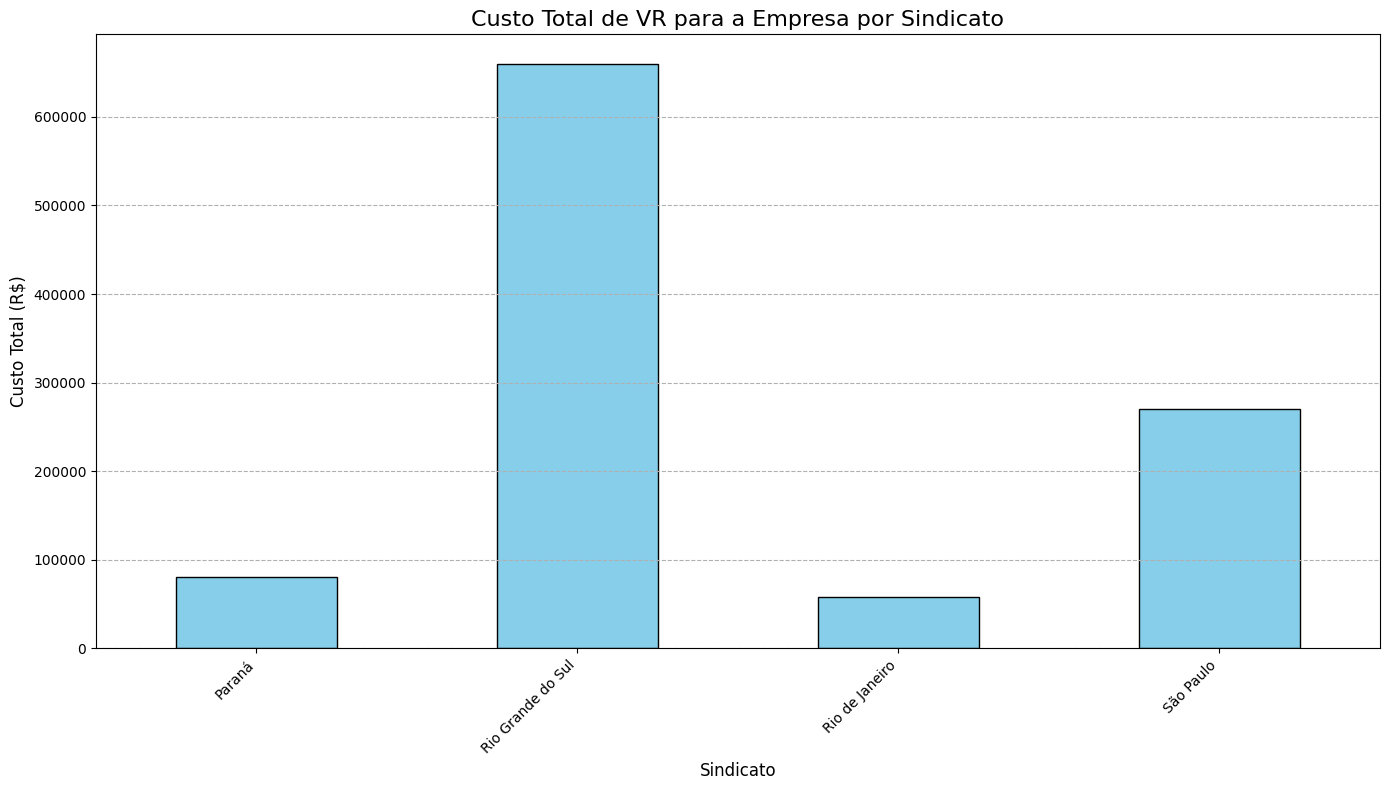

In [46]:
# PASSO 10 — (Opcional) Gerar Gráficos e Relatórios Visuais (Versão Corrigida)

%matplotlib inline
import matplotlib.pyplot as plt

def gerar_visualizacao(pergunta, df):
    p = pergunta.lower()

    if "gráfico" in p and "custo por sindicato" in p:
        # CORREÇÃO: Usando o nome da coluna de custo correto, que foi definido no Passo 7.
        coluna_custo = 'Custo Empresa (VR+VA)'

        if coluna_custo not in df.columns or 'Sindicato' not in df.columns:
            print(f"❌ Erro: As colunas '{coluna_custo}' ou 'Sindicato' não foram encontradas.")
            return

        # CORREÇÃO: Usando a coluna de custo correta para o cálculo.
        custo_por_sindicato = df.groupby('Sindicato')[coluna_custo].sum()

        # VERIFICAÇÃO: Se todos os custos são zero, informa o usuário.
        if custo_por_sindicato.sum() == 0:
            print("⚠️ AVISO: O custo total por sindicato é zero.")
            print("O gráfico não será gerado pois não há valores para exibir.")
            return

        # Geração do gráfico
        custo_por_sindicato.plot(kind='bar', figsize=(14, 8), color='skyblue', edgecolor='black')
        plt.title('Custo Total de VR para a Empresa por Sindicato', fontsize=16)
        plt.ylabel('Custo Total (R$)', fontsize=12)
        plt.xlabel('Sindicato', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("Tipo de visualização não reconhecido.")

# Exemplo de uso da função de visualização
# Usando o dataframe final do Passo 7, que se chama 'df_calculo'
if 'df_calculo' in locals():
    gerar_visualizacao("Me mostre o gráfico de custo por sindicato", df_calculo)
else:
    print("❌ DataFrame 'df_calculo' não encontrado. Execute os Passos 6 e 7 primeiro.")